<a href="https://colab.research.google.com/github/ayushxx7/PyTorchCourse/blob/master/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('13vrlKp7WamOb-YOus_sPGRWX-tINRxe9')

# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [125]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [126]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [127]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [128]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [129]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [130]:
your_name = "ayush" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [131]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [132]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,39.65775,2,no,14354.299732
997,63,female,44.58850,0,no,16248.923145
162,54,male,47.91600,1,no,12227.145840
824,60,male,29.42720,0,no,14652.617616
392,48,male,38.04845,1,no,10487.950843


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [133]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [134]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [135]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [136]:
categorical_cols = ['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [137]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

The minimum, maximum & average value of charges is 1312.592463, 74611.4007717 & 15577.608507718964 respectively.


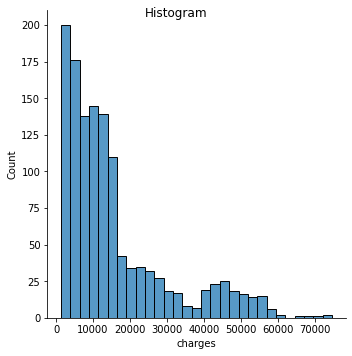

In [138]:
minimum = dataframe.charges.min()
maximum = dataframe.charges.max()
average = dataframe.charges.mean()
print(f"The minimum, maximum & average value of charges is {minimum}, {maximum} & {average} respectively.")

g = sns.displot(dataframe.charges)
g.fig.suptitle('Histogram')
plt.show()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [139]:
# !pip install jovian --upgrade -q

In [140]:
# import jovian

In [141]:
# jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ayushxx7/02-insurance-linear-regression


'https://jovian.ai/ayushxx7/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [142]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [143]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.     ,  0.     , 39.65775,  2.     ,  0.     ],
        [63.     ,  0.     , 44.5885 ,  0.     ,  0.     ],
        [54.     ,  1.     , 47.916  ,  1.     ,  0.     ],
        ...,
        [58.     ,  1.     , 38.7321 ,  1.     ,  0.     ],
        [32.     ,  0.     , 53.5062 ,  0.     ,  0.     ],
        [35.     ,  1.     , 21.6106 ,  1.     ,  0.     ]]),
 array([[14354.2997325],
        [16248.923145 ],
        [12227.14584  ],
        ...,
        [13977.552303 ],
        [ 4673.188026 ],
        [ 5986.305468 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [144]:
# inputs = torch.from_numpy(inputs_array)
# targets = torch.from_numpy(targets_array)
# The PyTorch Linear model crashed on dtype=float64
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [145]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [146]:
print(inputs[0:5])
print(targets[0:5])

tensor([[55.0000,  0.0000, 39.6577,  2.0000,  0.0000],
        [63.0000,  0.0000, 44.5885,  0.0000,  0.0000],
        [54.0000,  1.0000, 47.9160,  1.0000,  0.0000],
        [60.0000,  1.0000, 29.4272,  0.0000,  0.0000],
        [48.0000,  1.0000, 38.0485,  1.0000,  0.0000]])
tensor([[14354.2998],
        [16248.9229],
        [12227.1455],
        [14652.6172],
        [10487.9512]])


Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [147]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [148]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

In [149]:
print(len(train_ds), len(val_ds))
print(train_size, val_size)
print(len(dataset))
print(1017+254)

1017 254
1017 254
1271
1271


In [167]:
print(train_ds[0:5], val_ds[0:5])

(tensor([[50.0000,  0.0000, 34.0736,  3.0000,  0.0000],
        [58.0000,  0.0000, 27.5517,  0.0000,  0.0000],
        [52.0000,  0.0000, 30.6130,  2.0000,  1.0000],
        [53.0000,  1.0000, 25.8940,  1.0000,  0.0000],
        [30.0000,  0.0000, 24.1395,  3.0000,  0.0000]]), tensor([[12522.0918],
        [13845.5254],
        [28860.8809],
        [11776.5332],
        [ 6661.3135]])) (tensor([[22.0000,  1.0000, 32.4764,  0.0000,  0.0000],
        [59.0000,  1.0000, 49.7794,  1.0000,  1.0000],
        [31.0000,  1.0000, 46.4519,  2.0000,  0.0000],
        [48.0000,  0.0000, 33.1056,  1.0000,  0.0000],
        [43.0000,  0.0000, 30.3468,  0.0000,  0.0000]]), tensor([[ 1948.0496],
        [57295.1914],
        [ 5221.9502],
        [11053.4375],
        [ 8570.3066]]))


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [150]:
batch_size = 100

In [151]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [152]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[25.0000,  0.0000, 50.0033,  0.0000,  0.0000],
        [24.0000,  1.0000, 39.5670,  0.0000,  1.0000],
        [20.0000,  1.0000, 39.1979,  1.0000,  0.0000],
        [25.0000,  1.0000, 31.2664,  1.0000,  0.0000],
        [44.0000,  0.0000, 33.4505,  0.0000,  0.0000],
        [47.0000,  0.0000, 28.5560,  1.0000,  0.0000],
        [19.0000,  0.0000, 38.8531,  0.0000,  0.0000],
        [22.0000,  1.0000, 63.6218,  1.0000,  1.0000],
        [18.0000,  1.0000, 34.2551,  1.0000,  0.0000],
        [64.0000,  1.0000, 31.9561,  0.0000,  0.0000],
        [20.0000,  1.0000, 37.1288,  0.0000,  1.0000],
        [53.0000,  0.0000, 47.9160,  1.0000,  0.0000],
        [51.0000,  0.0000, 24.9260,  0.0000,  0.0000],
        [50.0000,  1.0000, 41.3820,  2.0000,  1.0000],
        [19.0000,  1.0000, 25.0470,  0.0000,  0.0000],
        [60.0000,  1.0000, 44.7155,  0.0000,  0.0000],
        [36.0000,  0.0000, 26.7833,  3.0000,  0.0000],
        [32.0000,  0.0000, 35.9794,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [153]:
# jovian.commit(project=project_name, environment=None)

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [178]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [172]:
x = inputs.shape
y = targets.shape
print(x, y)

torch.Size([1271, 5]) torch.Size([1271, 1])


In [218]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        self.loss_fn = F.l1_loss
        # tried mse_loss, hinge_embedding_loss, poisson_nll_loss
        # tried but failed due to error ctc_loss, cosine_embedding_loss

    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)    # current object is the model, so pass in self directly        
        # Calcuate loss
        loss = self.loss_fn(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs) 
        # Calculate loss
        loss = self.loss_fn(out, targets)                          # fill this
        # implement accurary later on    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [219]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [158]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.3042,  0.0130, -0.0085, -0.3482,  0.2885]], requires_grad=True),
 Parameter containing:
 tensor([-0.2646], requires_grad=True)]

One final commit before we train the model.

In [159]:
# jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ayushxx7/02-insurance-linear-regression


'https://jovian.ai/ayushxx7/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [160]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [220]:
result = evaluate(model, val_ds) # Use the the evaluate function
print(result)

{'val_loss': 15393.3603515625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [221]:
epochs = 1000
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15797.0469
Epoch [40], val_loss: 15796.3955
Epoch [60], val_loss: 15795.7451
Epoch [80], val_loss: 15795.0928
Epoch [100], val_loss: 15794.4424
Epoch [120], val_loss: 15793.7891
Epoch [140], val_loss: 15793.1396
Epoch [160], val_loss: 15792.4873
Epoch [180], val_loss: 15791.8359
Epoch [200], val_loss: 15791.1846
Epoch [220], val_loss: 15790.5342
Epoch [240], val_loss: 15789.8799
Epoch [260], val_loss: 15789.2295
Epoch [280], val_loss: 15788.5771
Epoch [300], val_loss: 15787.9248
Epoch [320], val_loss: 15787.2734
Epoch [340], val_loss: 15786.6221
Epoch [360], val_loss: 15785.9717
Epoch [380], val_loss: 15785.3203
Epoch [400], val_loss: 15784.6689
Epoch [420], val_loss: 15784.0186
Epoch [440], val_loss: 15783.3672
Epoch [460], val_loss: 15782.7139
Epoch [480], val_loss: 15782.0625
Epoch [500], val_loss: 15781.4111
Epoch [520], val_loss: 15780.7588
Epoch [540], val_loss: 15780.1064
Epoch [560], val_loss: 15779.4561
Epoch [580], val_loss: 15778.8037
Epoch [600], val_l

In [222]:
epochs = 500
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15758.6094
Epoch [40], val_loss: 15752.1045
Epoch [60], val_loss: 15745.5947
Epoch [80], val_loss: 15739.0703
Epoch [100], val_loss: 15732.5547
Epoch [120], val_loss: 15726.0469
Epoch [140], val_loss: 15719.5361
Epoch [160], val_loss: 15713.0264
Epoch [180], val_loss: 15706.5127
Epoch [200], val_loss: 15699.9971
Epoch [220], val_loss: 15693.4766
Epoch [240], val_loss: 15686.9658
Epoch [260], val_loss: 15680.4541
Epoch [280], val_loss: 15673.9404
Epoch [300], val_loss: 15667.4287
Epoch [320], val_loss: 15660.9189
Epoch [340], val_loss: 15654.4033
Epoch [360], val_loss: 15647.8799
Epoch [380], val_loss: 15641.3721
Epoch [400], val_loss: 15634.8564
Epoch [420], val_loss: 15628.3359
Epoch [440], val_loss: 15621.8154
Epoch [460], val_loss: 15615.3018
Epoch [480], val_loss: 15608.7734
Epoch [500], val_loss: 15602.2617


In [210]:
# 1e-2 gives nan
# epochs = 500
# lr = 1e-2
# history1 = fit(epochs, lr, model, train_loader, val_loader)

In [223]:
epochs = 1000
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15537.1416
Epoch [40], val_loss: 15472.0361
Epoch [60], val_loss: 15406.9111
Epoch [80], val_loss: 15341.8799
Epoch [100], val_loss: 15276.7334
Epoch [120], val_loss: 15211.5205
Epoch [140], val_loss: 15146.2812
Epoch [160], val_loss: 15081.1318
Epoch [180], val_loss: 15015.9990
Epoch [200], val_loss: 14950.9062
Epoch [220], val_loss: 14885.7256
Epoch [240], val_loss: 14820.6318
Epoch [260], val_loss: 14755.4893
Epoch [280], val_loss: 14690.2422
Epoch [300], val_loss: 14625.0576
Epoch [320], val_loss: 14559.8945
Epoch [340], val_loss: 14494.7686
Epoch [360], val_loss: 14429.7295
Epoch [380], val_loss: 14364.6748
Epoch [400], val_loss: 14299.6064
Epoch [420], val_loss: 14234.6982
Epoch [440], val_loss: 14169.9502
Epoch [460], val_loss: 14105.1924
Epoch [480], val_loss: 14040.7549
Epoch [500], val_loss: 13976.7158
Epoch [520], val_loss: 13912.8213
Epoch [540], val_loss: 13848.9844
Epoch [560], val_loss: 13785.2461
Epoch [580], val_loss: 13721.6797
Epoch [600], val_l

In [224]:
epochs = 2000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 12465.9229
Epoch [40], val_loss: 12415.8057
Epoch [60], val_loss: 12366.4805
Epoch [80], val_loss: 12317.7490
Epoch [100], val_loss: 12269.5557
Epoch [120], val_loss: 12221.7041
Epoch [140], val_loss: 12174.1592
Epoch [160], val_loss: 12127.3359
Epoch [180], val_loss: 12080.8916
Epoch [200], val_loss: 12034.8936
Epoch [220], val_loss: 11989.3086
Epoch [240], val_loss: 11943.7627
Epoch [260], val_loss: 11898.9639
Epoch [280], val_loss: 11854.8203
Epoch [300], val_loss: 11811.1904
Epoch [320], val_loss: 11767.7334
Epoch [340], val_loss: 11725.4375
Epoch [360], val_loss: 11683.7451
Epoch [380], val_loss: 11642.3643
Epoch [400], val_loss: 11600.9883
Epoch [420], val_loss: 11560.3564
Epoch [440], val_loss: 11519.7686
Epoch [460], val_loss: 11479.6123
Epoch [480], val_loss: 11439.5703
Epoch [500], val_loss: 11399.8467
Epoch [520], val_loss: 11360.7139
Epoch [540], val_loss: 11321.9639
Epoch [560], val_loss: 11283.1924
Epoch [580], val_loss: 11245.2725
Epoch [600], val_l

In [227]:
epochs = 4000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 9532.3799
Epoch [40], val_loss: 9519.4658
Epoch [60], val_loss: 9506.7031
Epoch [80], val_loss: 9493.8252
Epoch [100], val_loss: 9481.5713
Epoch [120], val_loss: 9469.8916
Epoch [140], val_loss: 9458.4785
Epoch [160], val_loss: 9447.1104
Epoch [180], val_loss: 9436.2217
Epoch [200], val_loss: 9425.7812
Epoch [220], val_loss: 9415.5283
Epoch [240], val_loss: 9405.3555
Epoch [260], val_loss: 9395.3457
Epoch [280], val_loss: 9385.4873
Epoch [300], val_loss: 9375.4697
Epoch [320], val_loss: 9365.7275
Epoch [340], val_loss: 9356.3984
Epoch [360], val_loss: 9347.1504
Epoch [380], val_loss: 9337.9375
Epoch [400], val_loss: 9328.8623
Epoch [420], val_loss: 9319.8604
Epoch [440], val_loss: 9311.1338
Epoch [460], val_loss: 9302.5576
Epoch [480], val_loss: 9294.1240
Epoch [500], val_loss: 9285.7080
Epoch [520], val_loss: 9277.6963
Epoch [540], val_loss: 9269.9619
Epoch [560], val_loss: 9262.5215
Epoch [580], val_loss: 9255.3135
Epoch [600], val_loss: 9248.0830
Epoch [620], v

In [231]:
epochs = 4000
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8870.7305
Epoch [40], val_loss: 8865.4189
Epoch [60], val_loss: 8860.0205
Epoch [80], val_loss: 8855.1494
Epoch [100], val_loss: 8850.3721
Epoch [120], val_loss: 8845.9287
Epoch [140], val_loss: 8841.5088
Epoch [160], val_loss: 8837.1807
Epoch [180], val_loss: 8832.8623
Epoch [200], val_loss: 8828.6523
Epoch [220], val_loss: 8824.6084
Epoch [240], val_loss: 8820.5898
Epoch [260], val_loss: 8816.6035
Epoch [280], val_loss: 8812.6572
Epoch [300], val_loss: 8808.6211
Epoch [320], val_loss: 8804.6191
Epoch [340], val_loss: 8800.5625
Epoch [360], val_loss: 8796.4346
Epoch [380], val_loss: 8792.4453
Epoch [400], val_loss: 8788.4795
Epoch [420], val_loss: 8784.3096
Epoch [440], val_loss: 8780.3193
Epoch [460], val_loss: 8776.4170
Epoch [480], val_loss: 8772.4248
Epoch [500], val_loss: 8768.4004
Epoch [520], val_loss: 8764.5371
Epoch [540], val_loss: 8760.6377
Epoch [560], val_loss: 8756.7002
Epoch [580], val_loss: 8752.8438
Epoch [600], val_loss: 8748.8955
Epoch [620], v

In [236]:
epochs = 6000
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8239.1562
Epoch [40], val_loss: 8237.5693
Epoch [60], val_loss: 8235.9453
Epoch [80], val_loss: 8234.3818
Epoch [100], val_loss: 8232.8174
Epoch [120], val_loss: 8231.2666
Epoch [140], val_loss: 8229.7236
Epoch [160], val_loss: 8228.2295
Epoch [180], val_loss: 8226.7695
Epoch [200], val_loss: 8225.2930
Epoch [220], val_loss: 8223.8467
Epoch [240], val_loss: 8222.4023
Epoch [260], val_loss: 8220.9814
Epoch [280], val_loss: 8219.6729
Epoch [300], val_loss: 8218.3281
Epoch [320], val_loss: 8216.8994
Epoch [340], val_loss: 8215.6064
Epoch [360], val_loss: 8214.3818
Epoch [380], val_loss: 8213.2559
Epoch [400], val_loss: 8212.0400
Epoch [420], val_loss: 8210.9336
Epoch [440], val_loss: 8209.8232
Epoch [460], val_loss: 8208.4268
Epoch [480], val_loss: 8207.2393
Epoch [500], val_loss: 8206.2041
Epoch [520], val_loss: 8205.0068
Epoch [540], val_loss: 8203.8311
Epoch [560], val_loss: 8202.7236
Epoch [580], val_loss: 8201.7666
Epoch [600], val_loss: 8200.9971
Epoch [620], v

In [242]:
epochs = 6000
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8142.4727
Epoch [40], val_loss: 8142.5220
Epoch [60], val_loss: 8142.2632
Epoch [80], val_loss: 8141.9961
Epoch [100], val_loss: 8141.9927
Epoch [120], val_loss: 8141.7793
Epoch [140], val_loss: 8141.5645
Epoch [160], val_loss: 8141.4321
Epoch [180], val_loss: 8141.2539
Epoch [200], val_loss: 8141.1812
Epoch [220], val_loss: 8141.1309
Epoch [240], val_loss: 8140.8296
Epoch [260], val_loss: 8140.6587
Epoch [280], val_loss: 8140.4961
Epoch [300], val_loss: 8140.4375
Epoch [320], val_loss: 8140.1797
Epoch [340], val_loss: 8140.1138
Epoch [360], val_loss: 8139.7695
Epoch [380], val_loss: 8139.6187
Epoch [400], val_loss: 8139.4077
Epoch [420], val_loss: 8139.3032
Epoch [440], val_loss: 8139.1113
Epoch [460], val_loss: 8138.9395
Epoch [480], val_loss: 8138.6851
Epoch [500], val_loss: 8138.5229
Epoch [520], val_loss: 8138.2964
Epoch [540], val_loss: 8138.1792
Epoch [560], val_loss: 8138.0063
Epoch [580], val_loss: 8137.8203
Epoch [600], val_loss: 8137.6992
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [243]:
val_loss = evaluate(model, val_ds)
print(val_loss)

{'val_loss': 7817.03759765625}


Let's log the final validation loss to Jovian and commit the notebook

In [233]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
# jovian.commit(project=project_name, environment=None)

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [197]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [244]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([22.0000,  1.0000, 32.4764,  0.0000,  0.0000])
Target: tensor([1948.0496])
Prediction: tensor(3811.3469)


In [245]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([29.0000,  0.0000, 37.7036,  0.0000,  0.0000])
Target: tensor([4614.0068])
Prediction: tensor(5511.8315)


In [246]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([18.0000,  0.0000, 46.3188,  0.0000,  0.0000])
Target: tensor([16535.6543])
Prediction: tensor(1558.3708)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [247]:
jovian.commit(project=project_name, environment=None)
# jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ayushxx7/02-insurance-linear-regression


'https://jovian.ai/ayushxx7/02-insurance-linear-regression'